# Boundary Value Problems

In [initial value problems](ode_initial.ipynb), we find a unique solution to an ODE by specifying initial conditions.  Another way to obtain a unique solution to an ODE (or PDE) is to specify boundary values.


## The Heat Equation

The [Heat Equation](https://en.wikipedia.org/wiki/Heat_equation) is a second-order PDE obeying

\begin{equation}
\Delta u(x, t) = \partial_t u(x, t)
\end{equation}
where $\Delta$ is the Laplacian operator
\begin{equation}
\Delta = \sum_i \partial_i^2
\end{equation}

This equation is in a steady state if $\partial_t u = 0$ (i.e. the solution is not changing with time).  

We'll consider the steady state of the heat equation on a 1-dimensional domain $[0,1]$, where we have the ends of the domain set to fixed temperatures.  In this case, we can write the solution as a boundary value problem for a second-order ODE:
\begin{equation}
\frac{d^2 u}{dx^2} = 0 \qquad u\in (0,1)\\
u(0) = a\\
u(1) = b
\end{equation}

You might think of this as describing the temperature of a metal bar which is placed between two objects of differing temperatures.

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

we'll introduce the variable $p = du / dx$ to obtain a system of first-order ODEs:
\begin{equation}
\frac{du}{dx} = p \\
\frac{dp}{dx} = 0
\end{equation}

with the same boundary conditions.  The variable `y = [u, p]` will be a 2-vector containing the state.

We'll use boundary conditions $y(0)[0] = u(0) = 5 = a$ and $y(1)[0] = u(1) = 1 = b$

Finally, we use [`solve_bvp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html) from `scipy.integrate` to solve the boundary value problem:

In [5]:
a = 5
b = 1

def f(x, y):
    "right hand side of ODE"
    return np.vstack([y[1,:], np.zeros(y.shape[1])])
    
def bc(ya, yb):
    "boundary condition residual"
    return np.array([ya[0] - a, yb[0] - b])

n = 100 # number of points
x = np.linspace(0,1,n)
y0 = np.zeros((2,n))

# solve bvp
sol = solve_bvp(f, bc, x, y0)

we can plot the solution value

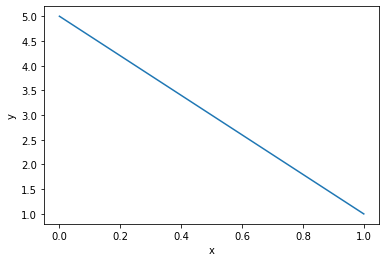

In [3]:
plt.plot(sol.x, sol.y[0,:])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

we see the solution is a linear function from (0,5) to (1,1).  You can check that such a linear function solves the BVP mathematically.

We also provide a non-zero right hand side: $\partial_t u(x,t) = f(x)$.

/opt/anaconda3/envs/pycourse/lib/python3.8/site-packages/scipy/integrate/_bvp.py:1092: RuntimeWarning: invalid value encountered in true_divide
  r_middle = 1.5 * col_res / h
/opt/anaconda3/envs/pycourse/lib/python3.8/site-packages/scipy/integrate/_bvp.py:591: RuntimeWarning: invalid value encountered in true_divide
  slope = (y[:, 1:] - y[:, :-1]) / h


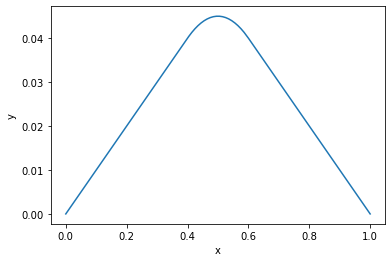

In [4]:
def f(x, y):
    "right hand side of ODE"
    src = -1*np.logical_and(x < 0.6, x > 0.4)
    return np.vstack([y[1,:], src])

def bc(ya, yb):
    "boundary condition residual"
    return np.array([ya[0], yb[0]])

n = 100 # number of points
x = np.linspace(0,1,n)
y0 = np.zeros((2,n))

# solve bvp
sol = solve_bvp(f, bc, x, y0)

plt.plot(sol.x, sol.y[0,:])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## The Wave Equation

The [Wave Equation](https://en.wikipedia.org/wiki/Wave_equation) is another second order PDE obeying
\begin{equation}
\Delta u(x, t) = \partial_t^2 u(x, t)
\end{equation}

One way to solve the Wave equaiton is to use separation of variables.  This gives solutions of the form
\begin{equation}
u(x,t) = v(x) e^{i\omega t}
\end{equation}

Where $v(x)$ satisfies the [Helmholtz equation](https://en.wikipedia.org/wiki/Helmholtz_equation)
\begin{equation}
\Delta v(x) = -\omega^2 v(x)
\end{equation}

In other words, $v(x)$ is an eigenvector of the Laplacian operator with eigenvalue $-\omega^2$.  The time dependent portion of the solution $e^{i\omega t}$ is simply a sinusoidal oscillation.

In a bounded domain, there is a discrete set of eigenvalues for the Laplacian.  We'll use the the construction $\Delta = -\partial^T \partial$

In [6]:
import scipy.sparse as sparse

# create matrix A to apply forward difference scheme
def forward_diff_matrix(n):
    data = []
    i = []
    j = []
    for k in range(n - 1):
        i.append(k)
        j.append(k)
        data.append(-1)

        i.append(k)
        j.append(k+1)
        data.append(1)
        
    # incidence matrix of the 1-d mesh
    return sparse.coo_matrix((data, (i,j)), shape=(n-1, n)).tocsr()

def Laplacian(n):
    """
    Create Laplacian on 1-dimensional grid with n nodes
    """
    B = forward_diff_matrix(n)
    return -B.T @ B

One has to be cautious with using $\Delta = -\partial^T \partial$. This comes from integration by part, for any two twice differentiable functions $f,g: \Omega\rightarrow \mathbb{R}$: $$\langle f, \Delta g \rangle := \int_\Omega f(x) \Delta g(x) dx = \int_\Omega \partial \left(f(x) \partial g(x)\right) dx - \int_\Omega\partial f(x)  \partial g(x) dx = f(x) \partial g(x)\vert_{\partial \Omega}- \langle \partial f, \partial g \rangle = 0 - \langle \partial f, \partial g \rangle$$
The last equality only holds under certain boundary conditions (if $f,g$ belongs to the class of $\{u\ \vert \ u(a) = 0, u(b) = 0\}$ when $\Omega = [a,b]$). We can also use such approximation when $\Omega = [a,b]$, and $u(a) = u_0, u(b) = u_1$.

In [7]:
n = 100

x = np.linspace(0,1,n)
L = Laplacian(n)

L[:4,:4].todense()

matrix([[-1,  1,  0,  0],
        [ 1, -2,  1,  0],
        [ 0,  1, -2,  1],
        [ 0,  0,  1, -2]])

We can use the [Gershgorin disk theorem](https://en.wikipedia.org/wiki/Gershgorin_circle_theorem) to bound the eigenvalues in the range $[-4,0]$, or plot them experimentally:

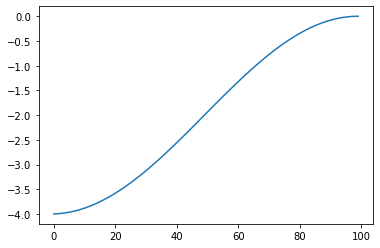

In [9]:
lam, V = la.eigh(L.todense())
plt.plot(lam)
plt.show()

Let's plot the eigenvectors with the 4 smallest-magnitude eigenvalues:

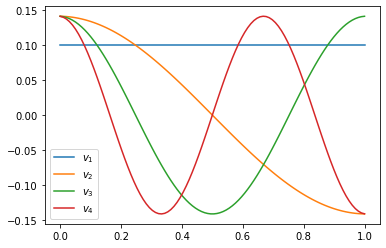

In [11]:
for i in range(1,5):
    plt.plot(x, V[:,-i], label=r"$v_{}$".format(i))
    
plt.legend()
plt.show()

the eigenvectors are of the form $v(x) = \cos(k \pi x)$ for $k= 0,1,2,\dots$

Now, let's say we want to solve the boundary value problem
\begin{equation}
\Delta v = -\omega^2 v\\
v[0] = a\qquad v[-1] = b
\end{equation}

Again, we can use `solve_bvp`

In [12]:
a = 5
b = 1
omega = 0.1

def f(x, y):
    "right hand side of ODE"
    return np.vstack([y[1,:], -omega**2 * y[0,:]])
    
def bc(ya, yb):
    "boundary condition residual"
    return np.array([ya[0] - a, yb[0] - b])

n = 100 # number of points
x = np.linspace(0,n,n)
y0 = np.zeros((2,n))

# solve bvp
sol = solve_bvp(f, bc, x, y0)

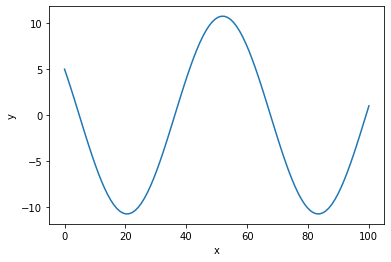

In [10]:
plt.plot(sol.x, sol.y[0,:])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Boundary Value Problems in SymPy

SymPy offers functionality that can be used to solve BVPs in its [`sym.solvers.ode.dsolve`](https://docs.sympy.org/latest/modules/solvers/ode.html) function

In [11]:
import sympy as sym
from sympy.solvers import ode

In [12]:
x = sym.symbols('x') # symbol
u = sym.Function('u') # symbolic function
eqn = u(x).diff(x).diff(x) # = 0
eqn

Derivative(u(x), (x, 2))

In [13]:
ode.classify_ode(eqn)

('nth_algebraic',
 'nth_linear_constant_coeff_homogeneous',
 'nth_linear_euler_eq_homogeneous',
 'Liouville',
 '2nd_power_series_ordinary',
 'nth_algebraic_Integral',
 'Liouville_Integral')

In [14]:
ode.dsolve(eqn, hint='nth_linear_constant_coeff_homogeneous')

Eq(u(x), C1 + C2*x)

in order to pass in boundary conditions, you can use the `ics` parameter

In [15]:
f = ode.dsolve(eqn, hint='nth_linear_constant_coeff_homogeneous', ics={u(0): 5, u(1): 1})
f

Eq(u(x), 5 - 4*x)

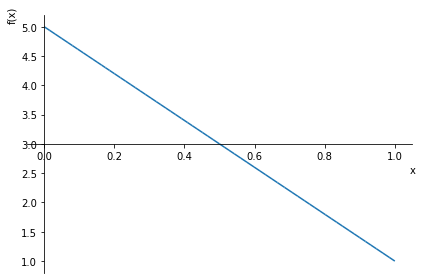

In [16]:
sym.plot(f.rhs, (x, 0, 1))

Let's try the Helmholtz equation now

In [17]:
omega = sym.Symbol('\omega')
eqn = u(x).diff(x).diff(x) + omega**2*u(x) # = 0
eqn

\omega**2*u(x) + Derivative(u(x), (x, 2))

In [18]:
ode.classify_ode(eqn)

('nth_linear_constant_coeff_homogeneous', '2nd_power_series_ordinary')

In [19]:
ode.dsolve(eqn, hint='nth_linear_constant_coeff_homogeneous')

Eq(u(x), C1*exp(-I*\omega*x) + C2*exp(I*\omega*x))

we see that the solution to the Helmholtz equation consists of sinusoidal waves.  Let's try putting in some boundary conditions

In [20]:
f = ode.dsolve(eqn, hint='nth_linear_constant_coeff_homogeneous', ics={u(0): 5, u(1): 1})
f

Eq(u(x), (exp(I*\omega) - 5)*exp(I*\omega*x)/(exp(2*I*\omega) - 1) - I*(5*exp(I*\omega) - 1)*exp(-I*\omega*x)/(2*sin(\omega)))

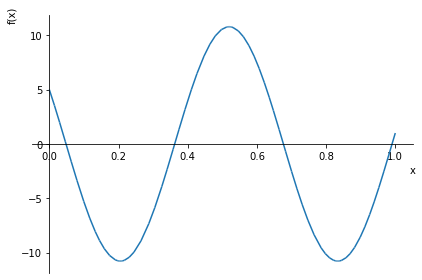

In [21]:
sym.plot(f.rhs.subs(omega, 10), (x, 0, 1))

## Solving BVPs using Optimization

You might also consider finding numerical solutions to BVPs using `scipy.optimize`.  Let's say we have a non-linear wave equation with boundary conditions
\begin{equation}
\Delta u = -f(u)\\
u(x) = 0 \qquad x\in \partial \Omega
\end{equation}
where $\partial \Omega$ is the boundary of the domain.  We can seek to solve the optimization problem
\begin{equation}
\mathop{\mathsf{minimize}}_u \|\Delta u + f(u)\|\\
\text{subject to } u(x) = 0 \qquad x \in \partial \Omega
\end{equation}

we'll use $f(u) = u^3$, modifying the example from the [SciPy Cookbook](https://scipy-cookbook.readthedocs.io/items/discrete_bvp.html)

In [24]:
def interior_laplacian(n):
    """
    Laplacian defined on the interior a length n grid
    """
    L = Laplacian(n).todok()
    L[0,0] = 0
    L[1,0] = 0
    L[-1,-1] = 0
    L[-2,-1] = 0
    return L.tocsr()

def interior_eye(n):
    diag = np.ones(n)
    diag[0] = 0
    diag[-1] = 0
    In = sparse.dia_matrix((diag, 0), shape=(n,n))
    return In
    
    
def interior_laplacian_2d(m, n):
    """
    Laplacian defined on the interior of a m x n grid
    """
    Lm = interior_laplacian(m)
    Im = interior_eye(m)
    Ln = interior_laplacian(n)
    In = interior_eye(n)
    return sparse.kron(Lm, In) + sparse.kron(Im, Ln)


In [25]:
m = 100
n = 100
L = interior_laplacian_2d(m,n)

def rhs(u):
    return u**3

def f(u, *args, **kwargs):
    # return vector of residuals
    Lu = L @ u
    return Lu + rhs(u)

We'll also define the jacobian

In [26]:
def compute_jac_indices(n):
    """
    compute indices for the Jacobian.  These are fixed for all iterations
    """
    i = np.arange(n)
    jj, ii = np.meshgrid(i, i)

    ii = ii.ravel()
    jj = jj.ravel()

    ij = np.arange(n**2)

    jac_rows = [ij]
    jac_cols = [ij]

    mask = ii > 0
    ij_mask = ij[mask]
    jac_rows.append(ij_mask)
    jac_cols.append(ij_mask - n)

    mask = ii < n - 1
    ij_mask = ij[mask]
    jac_rows.append(ij_mask)
    jac_cols.append(ij_mask + n)

    mask = jj > 0
    ij_mask = ij[mask]
    jac_rows.append(ij_mask)
    jac_cols.append(ij_mask - 1)

    mask = jj < n - 1
    ij_mask = ij[mask]
    jac_rows.append(ij_mask)
    jac_cols.append(ij_mask + 1)

    return np.hstack(jac_rows), np.hstack(jac_cols)



jac_rows, jac_cols = compute_jac_indices(100)


def jac(u, jac_rows=None, jac_cols=None):
    n = len(u)
    jac_values = np.ones_like(jac_cols, dtype=float)
    jac_values[:n] = -4 + 3*u**2
    return sparse.coo_matrix((jac_values, (jac_rows, jac_cols)), shape=(n, n))

In [31]:
import scipy.optimize as opt


res = opt.least_squares(
    f, 
    # np.random.rand(m*n), 
    np.ones(m*n),
    jac=jac, 
    kwargs={'jac_rows': jac_rows, 'jac_cols': jac_cols},
    verbose=1)

`xtol` termination condition is satisfied.
Function evaluations 27, initial cost 5.3960e+03, final cost 5.3860e+01, first-order optimality 1.15e+00.


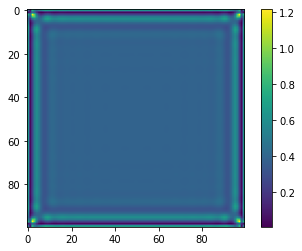

In [32]:
xsol = np.reshape(res.x, (100,100))

plt.imshow(xsol)
plt.colorbar()
plt.show()